In [1]:
# import libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

In [2]:
# Connect to SQLite DB (or create if not exists)
conn = sqlite3.connect('amazon_sales.db')
cursor = conn.cursor()

In [3]:
# Create table
cursor.execute('''
CREATE TABLE IF NOT EXISTS sales (
    OrderID TEXT,
    Date TEXT,
    Category TEXT,
    SKU TEXT,
    Item TEXT,
    Size TEXT,
    Qty INTEGER,
    Amount REAL,
    Status TEXT,
    ShipCity TEXT
)
''')


In [4]:
# Load CSV file
csv_path = "Amazon-Sale-Report.csv"
df = pd.read_csv(csv_path)

In [5]:
# Clean Date column and rename columns
df['Date'] = pd.to_datetime(df['Date'], format='%m-%d-%y', errors='coerce')
df.rename(columns={'Order ID': 'OrderID', 'ship-city': 'ShipCity'}, inplace=True)

In [6]:
# Insert data into table
insert_query = """
INSERT INTO sales (OrderID, Date, Category, SKU, Item, Size, Qty, Amount, Status, ShipCity)
VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?);
"""

for i, row in df.iterrows():
    data = (
        row['OrderID'],
        row['Date'].strftime('%Y-%m-%d') if pd.notnull(row['Date']) else None,
        row['Category'],
        row['SKU'],
        row['Item'] if 'Item' in row and pd.notnull(row['Item']) else None,  # safety check
        row['Size'] if 'Size' in row and pd.notnull(row['Size']) else None,
        int(row['Qty']) if pd.notnull(row['Qty']) else None,
        float(row['Amount']) if pd.notnull(row['Amount']) else None,
        row['Status'],
        row['ShipCity'] if pd.notnull(row['ShipCity']) else None
    )
    cursor.execute(insert_query, data)

conn.commit()
print("CSV data inserted successfully into SQLite.")

CSV data inserted successfully into SQLite.


In [7]:
# Plot bar charts
def plot_bar(data, x_col, y_col, title, xlabel, ylabel):
    plt.figure(figsize=(10,6))
    sns.barplot(x=data[x_col], y=data[y_col])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter('₹{x:,.0f}'))
    plt.tight_layout()
    plt.show()


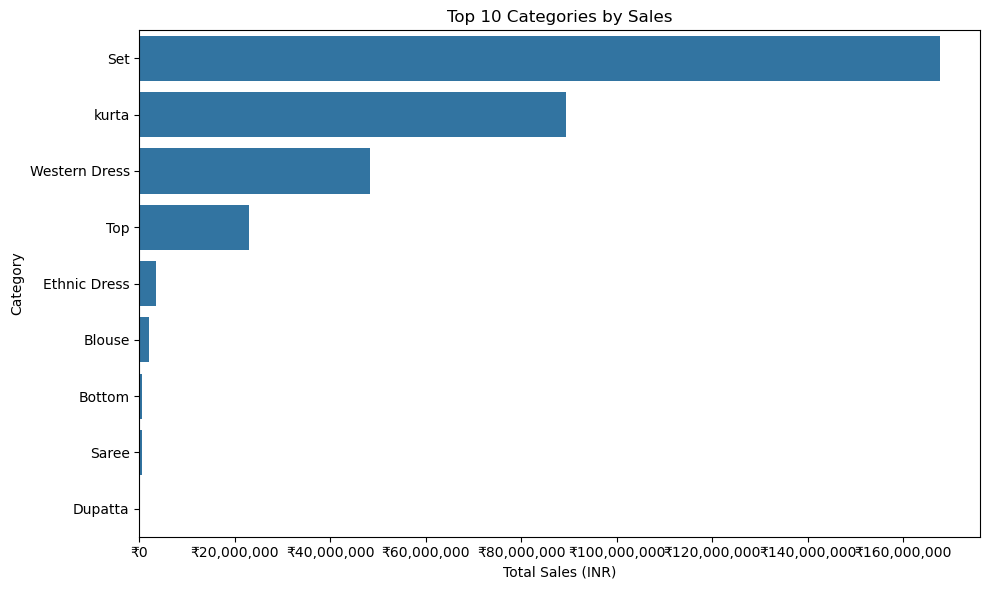

In [8]:
# Top Categories by Sales
query1 = """
SELECT Category, SUM(Amount) AS TotalSales
FROM sales
WHERE Qty > 0 AND Status NOT LIKE '%Cancelled%'
GROUP BY Category
ORDER BY TotalSales DESC
LIMIT 10;
"""
top_categories = pd.read_sql_query(query1, conn)
plot_bar(top_categories, 'TotalSales', 'Category', 'Top 10 Categories by Sales', 'Total Sales (INR)', 'Category')

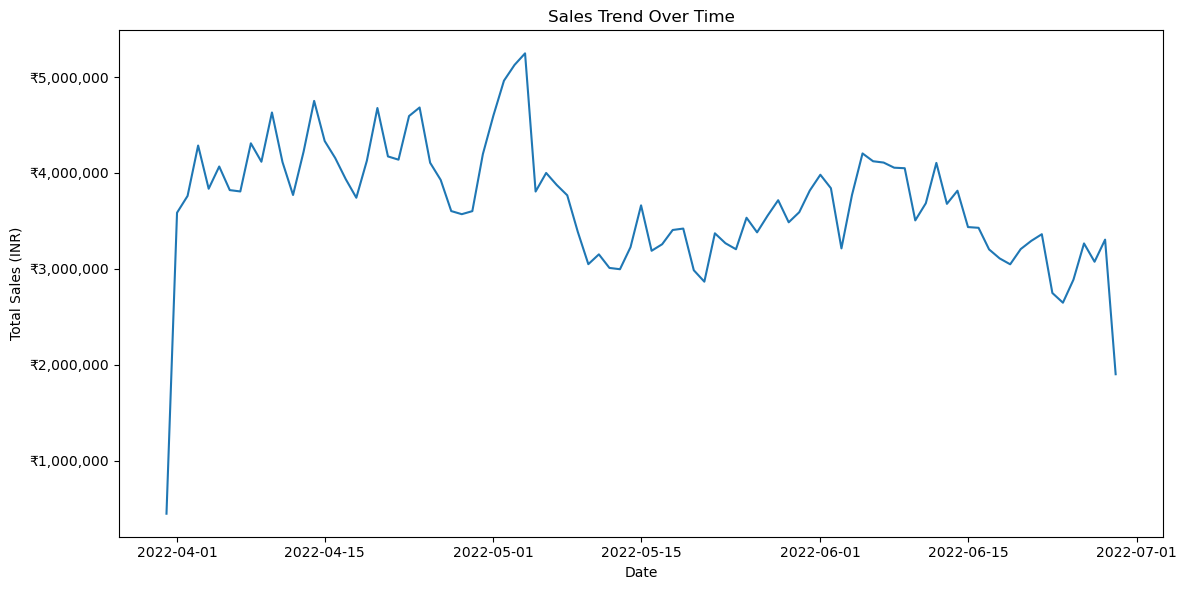

In [9]:
# Sales Trend Over Time
query2 = """
SELECT Date, SUM(Amount) AS TotalSales
FROM sales
WHERE Qty > 0 AND Status NOT LIKE '%Cancelled%'
GROUP BY Date
ORDER BY Date;
"""
sales_trend = pd.read_sql_query(query2, conn)
plt.figure(figsize=(12,6))
plt.plot(pd.to_datetime(sales_trend['Date']), sales_trend['TotalSales'])
plt.title('Sales Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales (INR)')
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('₹{x:,.0f}'))
plt.tight_layout()
plt.show()

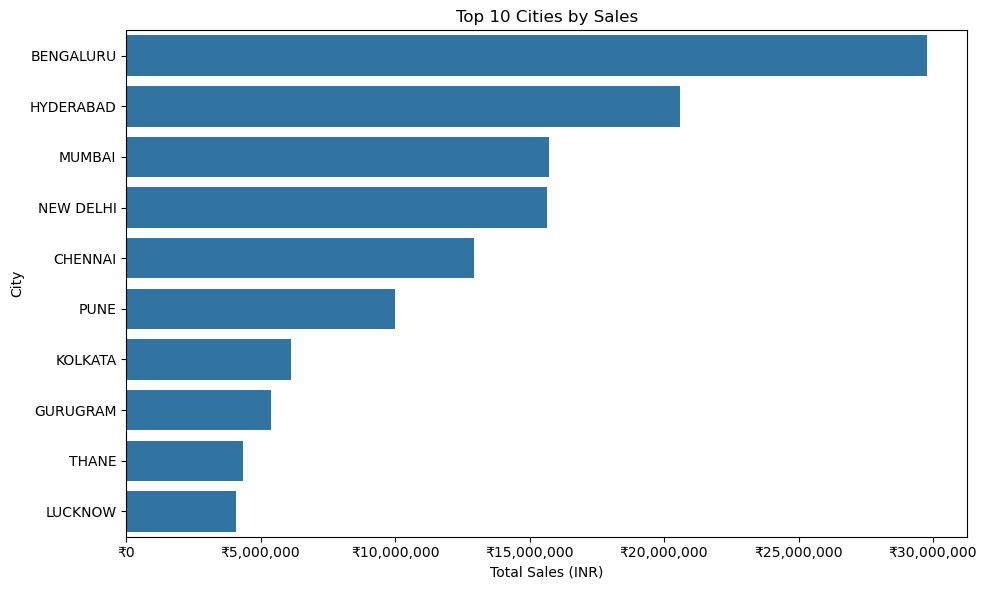

In [10]:
# Top Cities by Sales
query3 = """
SELECT ShipCity, SUM(Amount) AS TotalSales
FROM sales
WHERE Qty > 0 AND Status NOT LIKE '%Cancelled%'
GROUP BY ShipCity
ORDER BY TotalSales DESC
LIMIT 10;
"""
top_cities = pd.read_sql_query(query3, conn)
plot_bar(top_cities, 'TotalSales', 'ShipCity', 'Top 10 Cities by Sales', 'Total Sales (INR)', 'City')

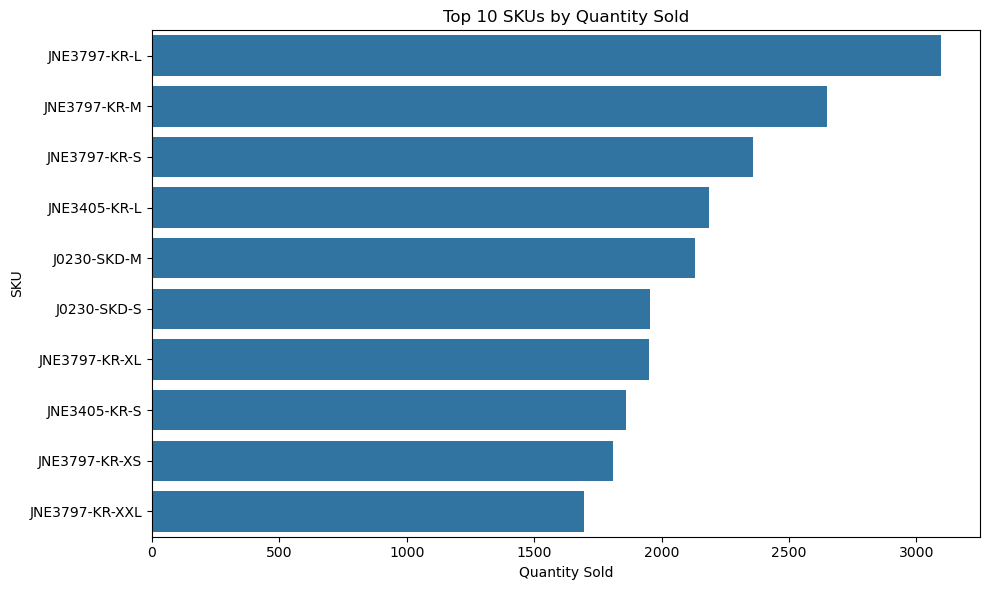

In [11]:
# Top Products by Quantity Sold
query4 = """
SELECT SKU, SUM(Qty) AS TotalQty
FROM sales
WHERE Qty > 0 AND Status NOT LIKE '%Cancelled%'
GROUP BY SKU
ORDER BY TotalQty DESC
LIMIT 10;
"""
top_products = pd.read_sql_query(query4, conn)
plt.figure(figsize=(10,6))
sns.barplot(x=top_products['TotalQty'], y=top_products['SKU'])
plt.title('Top 10 SKUs by Quantity Sold')
plt.xlabel('Quantity Sold')
plt.ylabel('SKU')
plt.tight_layout()
plt.show()

In [12]:
# Count Cancelled Orders
query5 = "SELECT COUNT(*) AS CancelledCount FROM sales WHERE Status LIKE '%Cancelled%';"
cancelled_count = pd.read_sql_query(query5, conn)
print("Total Cancelled Orders:", cancelled_count['CancelledCount'].iloc[0])

Total Cancelled Orders: 85925


In [57]:
# Close connection
cursor.close()
conn.close()